In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
header = [np.array(['partitioning', 'cfg', 'univmon', 'univmon', 'univmon_greedy', 
                    'univmon_greedy', 'univmon_greedy_rows', 'univmon_greedy_rows', 
                    'netmon', 'netmon']), 
         np.array(['', '', 'throughput', 'resources', 'throughput', 'resources', 
                   'throughput', 'resources', 'throughput', 'resources'])]
solvers = ['univmon', 'univmon_greedy', 'univmon_greedy_rows', 'netmon']

def get_df(file_path):
    df = pd.read_csv(file_path)
    df = df.drop(df.columns[-1], axis=1)
    df.columns = header
    df = df.replace(' -', np.nan)
    df['univmon'] = df['univmon'].astype('float')
    return df

In [3]:
def scatter_thr_resources(df, selection = [3, 9]):
    markers = ['o', 'x', 's', 'v']
    plt.figure(figsize=(15, 10))
    idx = 0
    for solver in solvers:
        plt.scatter(df[solver]['resources'][df['cfg'].isin(selection)], 
                    df[solver]['throughput'][df['cfg'].isin(selection)],
                    label=solver, marker=markers[idx])
        idx += 1

    plt.legend()
    plt.ylabel('Throughput (Mpps)')
    plt.xlabel('Resources')
    plt.show()

In [4]:
def thr(df):
    plt.figure(figsize=(20, 10))
    for solver in solvers:
        plt.plot(df.index, df[solver]['throughput'], label=solver)

    plt.ylabel('Throughput (Mpps)')
    plt.xlabel('Sample')
    plt.legend()
    plt.show()

In [5]:
def res(df):
    plt.figure(figsize=(20, 10))
    for solver in solvers:
        plt.plot(df.index, df[solver]['resources'], label=solver)

    plt.ylabel('Resources')
    plt.xlabel('Sample')
    plt.legend()
    plt.show()

In [6]:
def partition_sensitivity(df):
    pars = ['h', 'v', 'hv', 'n']
    plt.figure(figsize=(15, 10))
    for par in pars:
        ys = df['univmon']['throughput'][df['partitioning'] == par]
        for solver in solvers[1:]:
            ys.append(df[solver]['throughput'][df['partitioning'] == par])

        xs = df['univmon']['resources'][df['partitioning'] == par]
        for solver in solvers[1:]:
            ys.append(df[solver]['resources'][df['partitioning'] == par])

        plt.scatter(xs, ys, label=par)

    plt.ylabel('Throughput (Mpps)')
    plt.xlabel('Resources')
    plt.legend()
    plt.show()

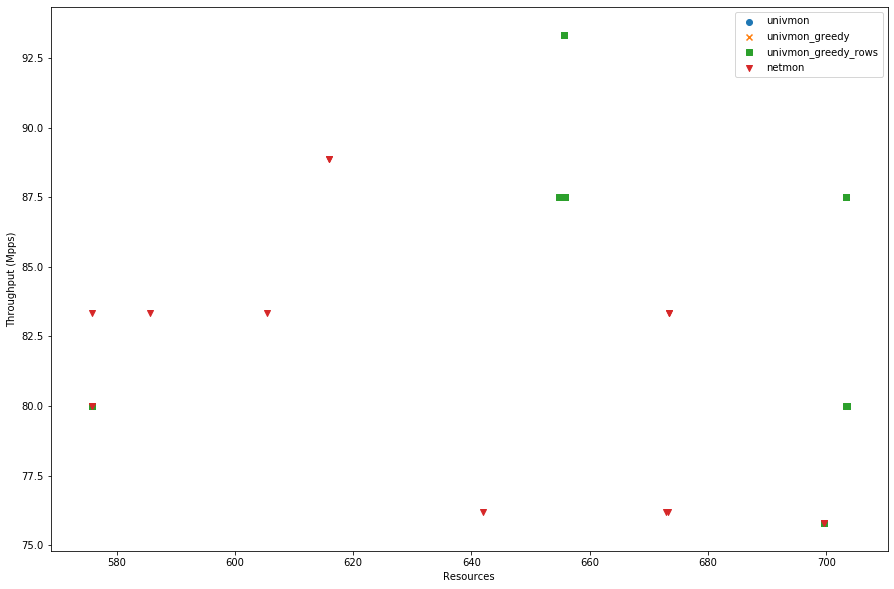

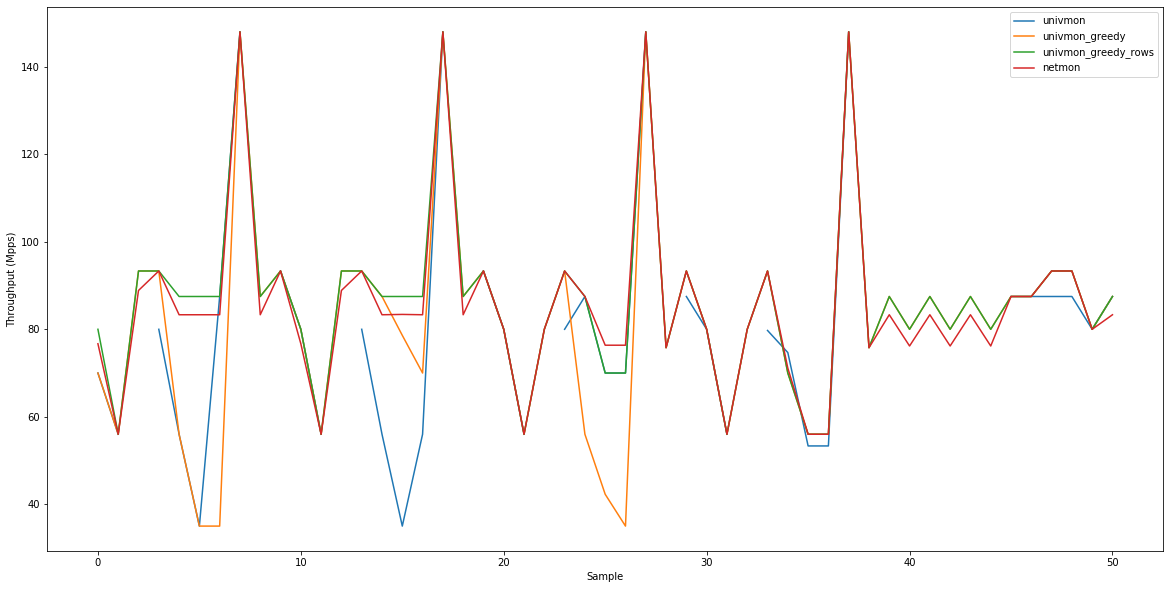

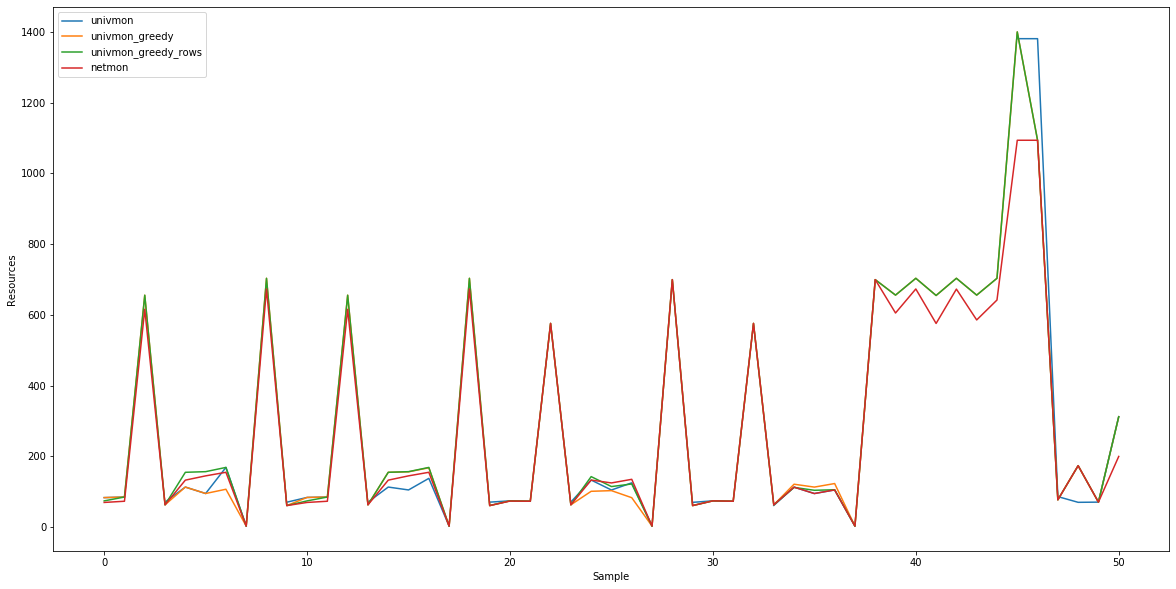

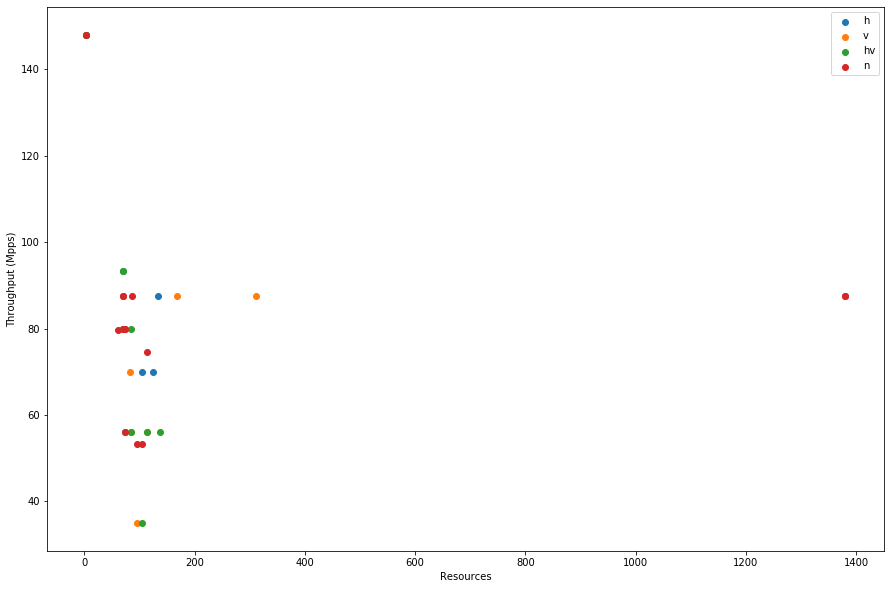

In [7]:
df = get_df("../outputs/sensitivity.csv")
plotters = [scatter_thr_resources, thr, res, partition_sensitivity]

for plotter in plotters:
    plotter(df)

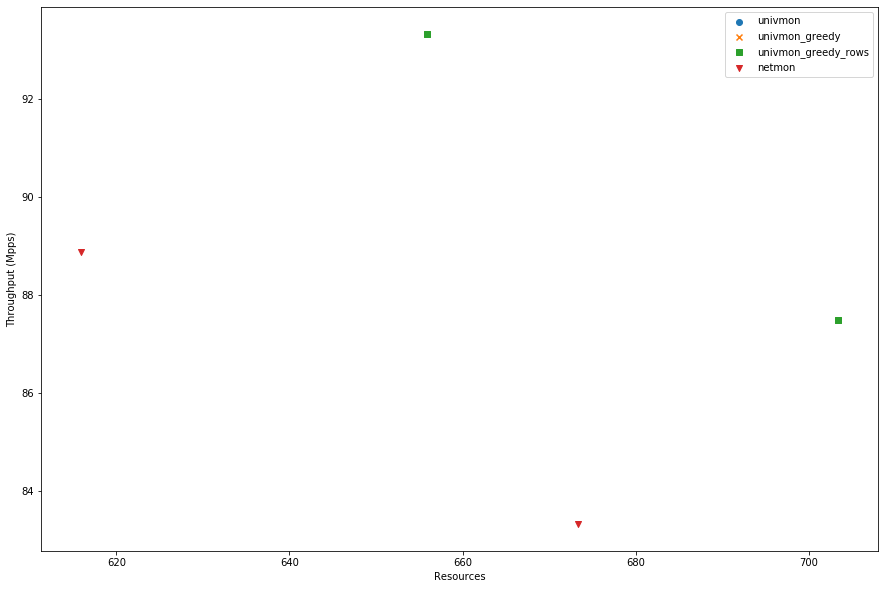

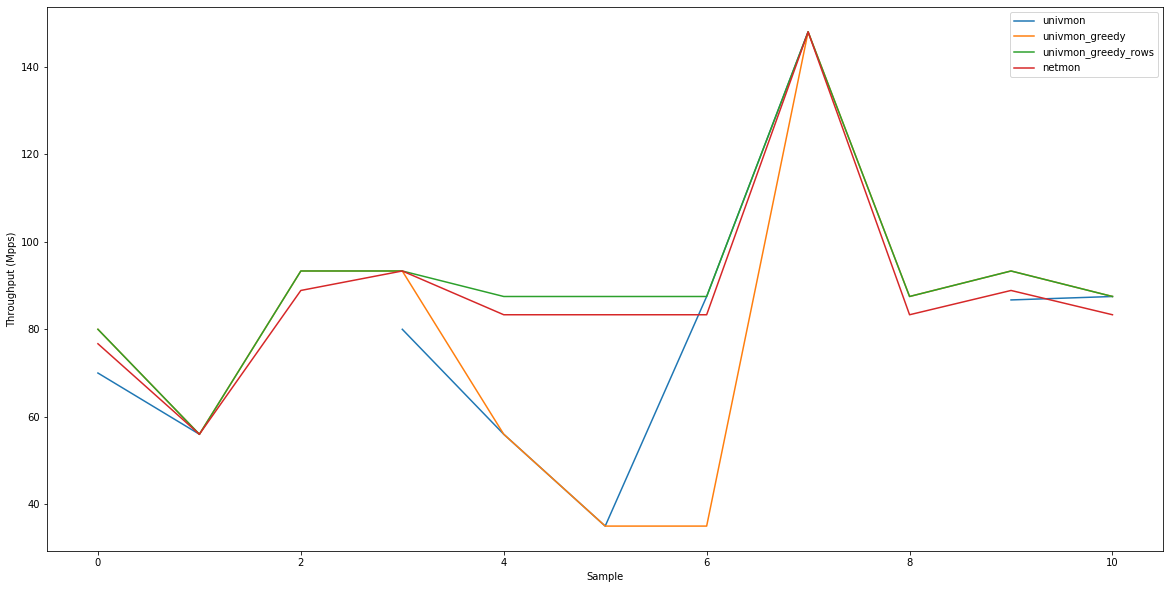

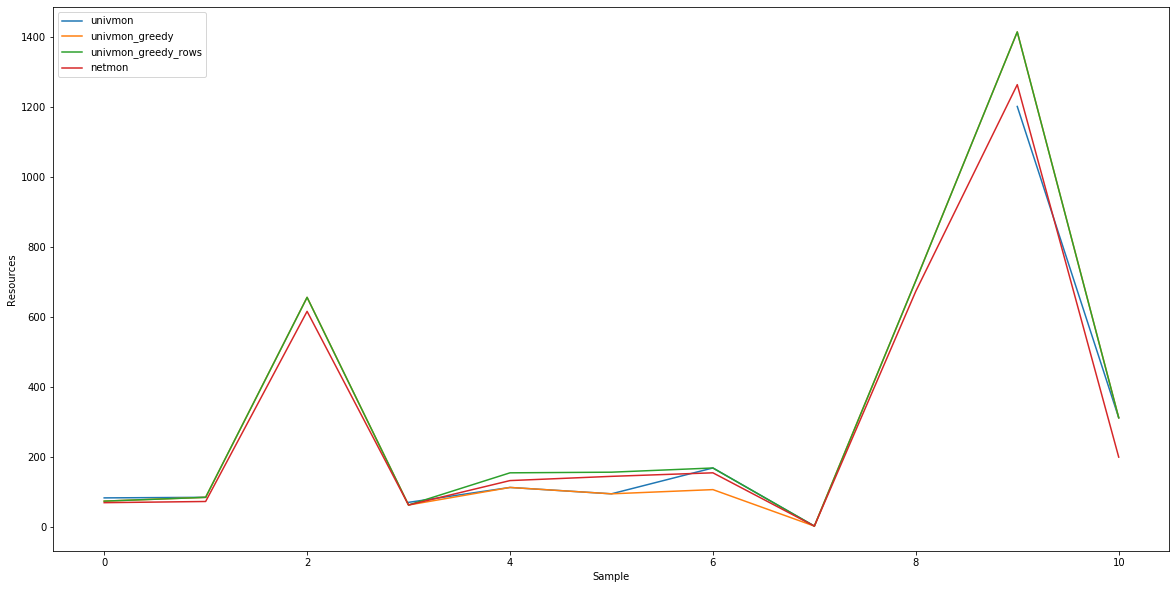

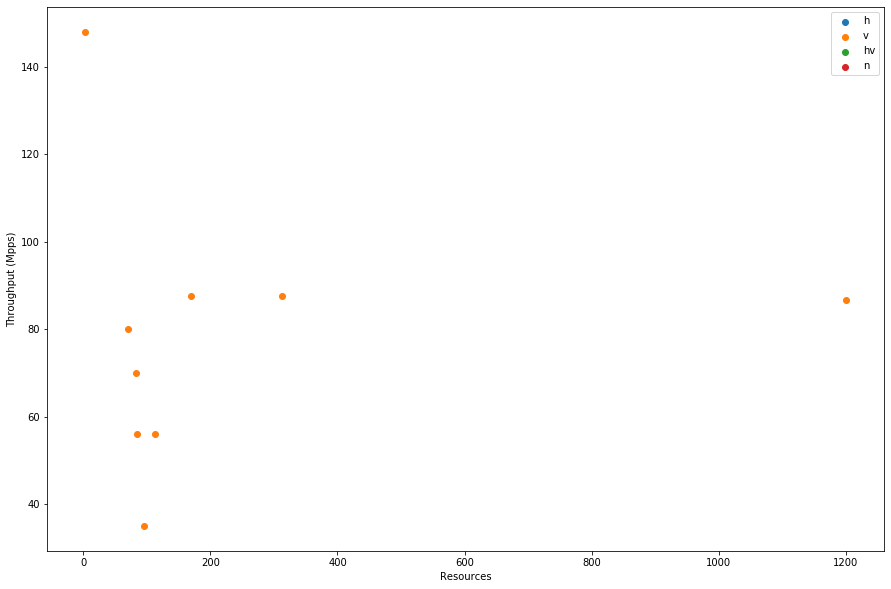

In [8]:
df2 = get_df("../outputs/sensitivity2.csv")

for plotter in plotters:
    plotter(df2)

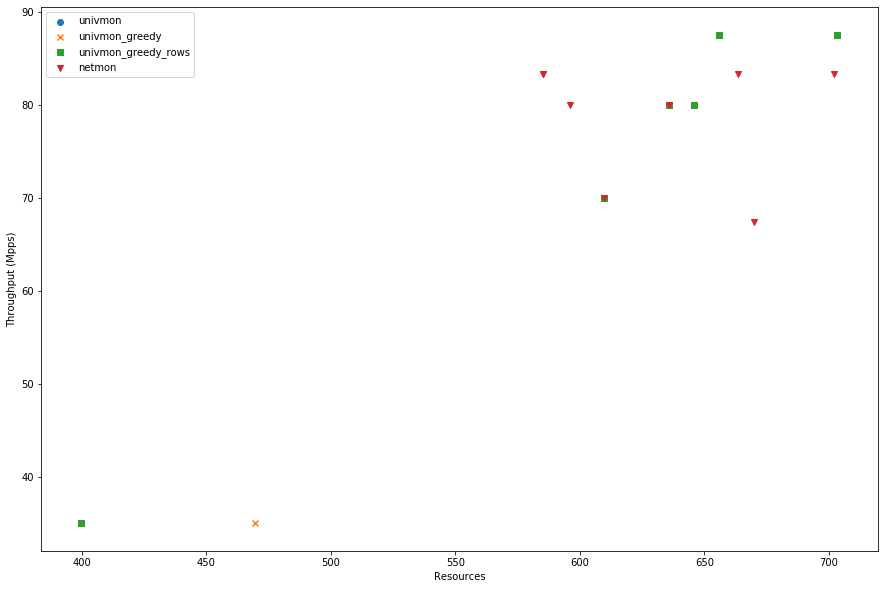

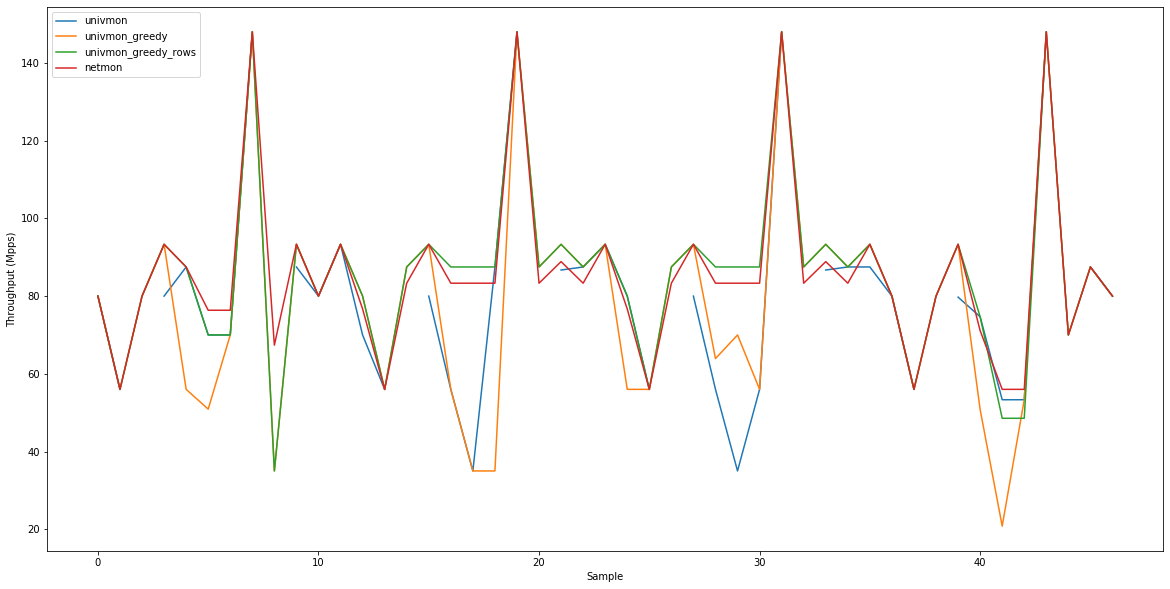

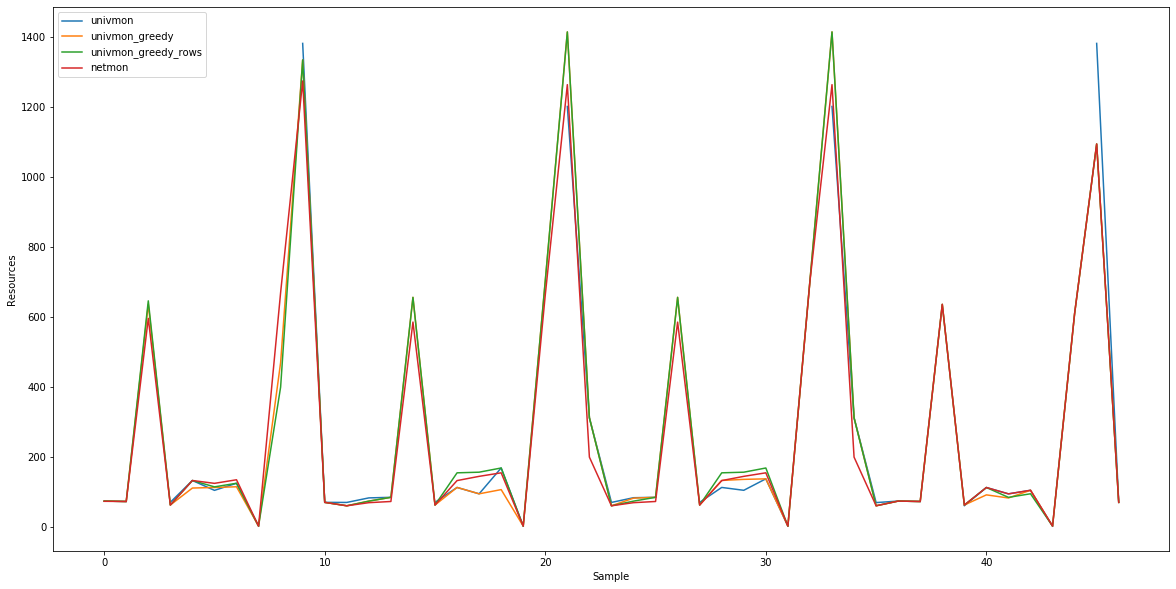

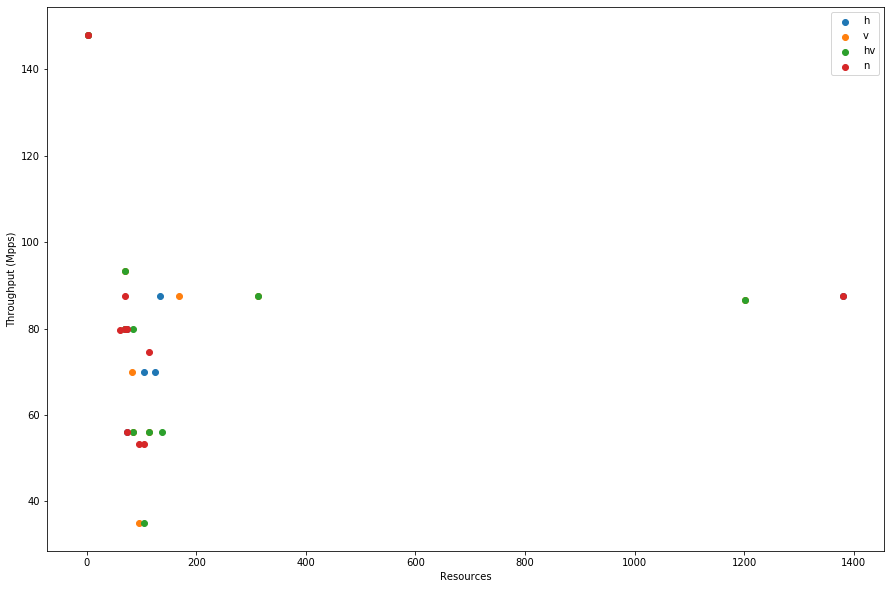

In [9]:
df2 = get_df("../outputs/sensitivity3.csv")

for plotter in plotters:
    plotter(df2)